## O Dataset

O WiLI-2018 é um dataset público que conta com textos de 235 idiomas, os quais foram extraídos a partir de artigos publicados no Wikipedia.

Disponível no Kaggle ([link](https://www.kaggle.com/datasets/sharansmenon/wili-2018)), o dataset é composto por 2 arquivos .csv, onde o primeiro, intitulado ```data.csv```, possui a coluna **text** para o texto e a coluna **class** para a classe do texto, que é um código de 3 letras determinando o idioma do texto.

O segundo arquivo , intitulado ```labels.csv```, dispõe de 9 colunas, sendo elas: **Label** (equivalente à coluna **class** do outro arquivo), **English** (nome do idioma em inglês), **Wiki Code** (código do idioma na Wikipedia), **ISO 369-3** (código ISO), **German** (nome do idioma em alemão), **Language family** (família do idioma), **Writing system** (sistema de escrita), **Remarks** (informação adicional) e **Synonyms** (sinônimos para o nome do idioma).

<br></br>
O objetivo desse trabalho é entender os padrões nos textos de cada idioma e criar um modelo capaz de prever o idioma de novas entradas de textos.

Inicialmente, realizaremos o pré-processamento do código, arrumando as tabelas de um jeito para favorecer a criação do modelo consistente e extraindo algumas métricas para garantir uma divisão de treinamento e teste não enviesada.


## Pré-Processamento

### Importação das Bibliotecas

In [10]:
pip install pandas numpy scikit-learn matplotlib wordcloud seaborn

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: C:\Users\ASUS\AppData\Local\Programs\Python\Python313\python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import string

from wordcloud import WordCloud

from statistics import mean, stdev

from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB, CategoricalNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import seaborn as sns
import joblib

### Download e Inicialização do Dataset

In [51]:
# Abrir os dois dataframes no pandas
data = pd.read_csv('data.csv')
labels = pd.read_csv('labels.csv', sep=';') # Esse arquivo possui os valores separados por ponto e vírgula e não pelo padrão vírgula, portanto adicionamos sep=';'

O dataset nos deu dois arquivos **csv** diferentes, `data.csv` e `labels.csv` que abrimos respectivamente como os dataframes `data` e `labels`. Veremos em breve que essa separação existe para evitar a repetição de colunas que não interessam para o escopo de nosso problema, portanto eventualmente uniremos ambos os dataframes em um só: `df` que usaremos para o treinamento e teste do modelo.

### Limpeza das tabelas

#### Conteúdo e quantidades em `data.csv`

Vejamos as primeiras linhas de `data`, a fim de entender a estrutura do objeto.

In [52]:
data.head()

,text,class
0,Klement Gottwaldi surnukeha palsameeriti ning ...,est\n
1,"Sebes, Joseph; Pereira Thomas (1961) (på eng)....",swe\n
2,भारतीय स्वातन्त्र्य आन्दोलन राष्ट्रीय एवम क्षे...,mai\n
3,"Après lo cort periòde d'establiment a Basilèa,...",oci\n
4,ถนนเจริญกรุง (อักษรโรมัน: Thanon Charoen Krung...,tha\n


Uma breve verificação de nulos em `data`.

In [53]:
data.isnull().sum()

text     0
class    0
dtype: int64

Podemos perceber que não há nenhuma linha de `data` com valores nulos.

Além disso, percebemos também que a coluna **class** de `data` contém um sufixo **'\n'** indesejado. Executamos, então, a seguinte função para remover todas as suas ocorrências na coluna.

In [54]:
def remove_nl(language):
    language = language.replace('\n', '')
    return language

data['class'] = data['class'].apply(remove_nl)

data.head()

,text,class
0,Klement Gottwaldi surnukeha palsameeriti ning ...,est
1,"Sebes, Joseph; Pereira Thomas (1961) (på eng)....",swe
2,भारतीय स्वातन्त्र्य आन्दोलन राष्ट्रीय एवम क्षे...,mai
3,"Après lo cort periòde d'establiment a Basilèa,...",oci
4,ถนนเจริญกรุง (อักษรโรมัน: Thanon Charoen Krung...,tha


Vamos conferir a quantidade de classes (idiomas) diferentes no dataframe, assim como a frequência de cada classe e de cada texto.

In [55]:
len(data['class'].unique())

235

In [56]:
data['class'].value_counts().unique() # Frequência de cada classe (o unique evita repetição do mesmo valor)

array([1000])

Todos os idiomas aparecem 1000 vezes.

In [57]:
data['text'].value_counts().unique() # Frequência de cada texto (o unique evita repetição do mesmo valor)

array([638, 402, 221, 197, 124, 122, 105,  99,  96,  92,  88,  83,  66,
        55,  54,  52,  48,  46,  45,  44,  43,  37,  35,  34,  32,  31,
        30,  29,  28,  26,  25,  22,  21,  19,  18,  17,  16,  15,  13,
        12,  11,  10,   9,   8,   7,   6,   5,   4,   3,   2,   1])

De acordo com as duas células de código acima, `data` tem dados de 235 idiomas e 1000 textos de cada um, mas existem textos que aparecem mais de uma vez. É necessário remover essas ocorrências extras para evitar que o modelo fique enviesado ao treinar nesses textos.

In [58]:
data.drop_duplicates(subset='text', inplace=True) # Subset indica a coluna que os elementos duplicados estão e inplace sobreescreve 'data'.
data['text'].value_counts().unique()

array([1])

Pronto, agora todos os textos têm frequência igual a 1.

---

O próximo passo é remover tudo o que não é palavra dos textos. Serão removidos dígitos e pontuações. Isso será interessante para uma futura possível vetorização dos textos, onde vamos nos importar apenas com as palavras, e não com os demais caracteres. A seguir, um exemplo de um texto qualquer:

In [59]:
data['text'].iloc[5]

"Mudde 14, 2012tti, TNQ USA raxibacumab antiraaksii qilleensaan seenuu yaaluu akka limmoodhaan kennamu eeyyame. Raxibacumab antiibodii monoclonial kan summii Baasiles Antiraasisiin uummamu sana halaksiisa. Summiin kun tishuurratti miidhama hin fayyinee fi du'a fida. Antiibodii monoclonial kun pirootiinii antiibodii namaa fakkaatu yoo ta'u qaamota alaa nama keessa seenan kan akka baakteeriyaa fi vaayiresii barbaadanii balleessa.\n"

Analisando os textos do dataset, percebemos que vários possuem um **'\n'** no final, também iremos fazer essa remoção.

Vamos escrever uma função para remover as pontuações, dígitos e possíveis espaços extras. Além disso, todo o texto será convertido para letras minúsculas a fim de padronizar ao máximo as palavras e evitar que palavras iguais escritas de formas diferentes sejam entendidas como palavras diferentes. Também iremos aproveitar a função escrita para remover o **'\n'** no fim do texto.

**OBS**: Alguns idiomas, por possuirem um alfabeto próprio, também possuem caracteres próprios para a pontuação, como o ponto final ideográfico presente no cantonês ```。``` com código unicode U+3002. Pela complexidade de mapear todas as pontuações de todos os idiomas presentes no dataset, escolhemos por retirar apenas aqueles básicos presentes na tabela ASCII e que são retornados pelo ```string.punctuation```. Um dos métodos usados futuramente (Tf-Idf Vectorizer) irá cuidar desse problema.

In [60]:
def pre_processing(text):
  text = text.translate(str.maketrans('', '', string.punctuation)) # Removendo pontuação

  text = text.translate(str.maketrans('', '', string.digits)) # Removendo dígitos

  text = " ".join(text.split()) # Removendo espaços extras

  text = text.lower() # Convertendo para minúsculo (aplicado a todas as línguas)

  return text

In [61]:
data['text'] = data['text'].apply(pre_processing).apply(remove_nl)

data.head()

,text,class
0,klement gottwaldi surnukeha palsameeriti ning ...,est
1,sebes joseph pereira thomas på eng the jesuits...,swe
2,भारतीय स्वातन्त्र्य आन्दोलन राष्ट्रीय एवम क्षे...,mai
3,après lo cort periòde destabliment a basilèa t...,oci
4,ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...,tha


O mesmo texto analisado anteriormente, mas sem a pontuação:

In [62]:
data['text'].iloc[5]

'mudde tti tnq usa raxibacumab antiraaksii qilleensaan seenuu yaaluu akka limmoodhaan kennamu eeyyame raxibacumab antiibodii monoclonial kan summii baasiles antiraasisiin uummamu sana halaksiisa summiin kun tishuurratti miidhama hin fayyinee fi dua fida antiibodii monoclonial kun pirootiinii antiibodii namaa fakkaatu yoo tau qaamota alaa nama keessa seenan kan akka baakteeriyaa fi vaayiresii barbaadanii balleessa'

Só temos palavras, como o esperado.

---

#### Conteúdo e quantidades em `labels.csv`

Vejamos o outro frame `labels`.

In [63]:
labels.head()

,Label,English,Wiki Code,ISO 369-3,German,Language family,Writing system,Remarks,Synonyms
0,ace,Achinese,ace,ace,Achinesisch,Austronesian,NaN,NaN,NaN
1,afr,Afrikaans,af,afr,Afrikaans,Indo-European,NaN,NaN,NaN
2,als,Alemannic German,als,gsw,Alemannisch,Indo-European,NaN,(ursprünglich nur Elsässisch),NaN
3,amh,Amharic,am,amh,Amharisch,Afro-Asiatic,NaN,NaN,NaN
4,ang,Old English,ang,ang,Altenglisch,Indo-European,NaN,(ca. 450-1100),Angelsächsisch


Uma breve busca por valores nulos.

In [64]:
labels.isnull().sum()

Label                1
English              0
Wiki Code            0
ISO 369-3            4
German               0
Language family      0
Writing system     196
Remarks            225
Synonyms           225
dtype: int64

Existe uma label com valor nulo, iremos investigar qual é.

In [65]:
labels[labels['Label'].isna()]

,Label,English,Wiki Code,ISO 369-3,German,Language family,Writing system,Remarks,Synonyms
142,NaN,Min Nan Chinese,zh-min-nan,NaN,Min Nan,Sino-Tibetan,NaN,NaN,NaN


Ao olharmos o arquivo original do dataset percebemos que para esse idioma o valor da coluna **Label** era "nan", porém, quando abrimos o csv no *pandas*, ele automaticamente o converteu em "NaN" que é interpretado como nulo. Logo, será necessário alterar manualmente a entrada nessa linha para o idioma correto.

Como a coluna **Label** só possui essa linha como valor nulo "NaN", usaremos a função **fillna**, que troca todos os nulos, para trocar esse valor para "nan".

In [66]:
labels['Label'] = labels['Label'].fillna("nan")

In [67]:
labels.isnull().sum()

Label                0
English              0
Wiki Code            0
ISO 369-3            4
German               0
Language family      0
Writing system     196
Remarks            225
Synonyms           225
dtype: int64

In [68]:
labels[labels["Label"] == "nan"].head()

,Label,English,Wiki Code,ISO 369-3,German,Language family,Writing system,Remarks,Synonyms
142,nan,Min Nan Chinese,zh-min-nan,NaN,Min Nan,Sino-Tibetan,NaN,NaN,NaN


Pronto! Agora o dataset `labels` está correto.

### Junção dos datasets

É evidente que a nossa coluna mais importante é a coluna **Label**, visto que ela é a coluna comum com a tabela `data` e também a classe do nosso problema. Por uma questão semântica, é interessante trocar as siglas dos idiomas: *ace*, *afr*... para o nome disponível em inglês, no caso: *Achinese* e *Afrikaans*. Então a coluna **English** nos interessa também. Como as duas colunas específicadas dependem uma da outra, podemos então executar um *join*, usando as colunas *class* e *Label* e unificando as duas tabelas `data` e `labels` em `df`.

In [69]:
df = data.join(labels.set_index("Label"), on="class")
df.head()

,text,class,English,Wiki Code,ISO 369-3,German,Language family,Writing system,Remarks,Synonyms
0,klement gottwaldi surnukeha palsameeriti ning ...,est,Estonian,et,est,Estnisch,Uralic,NaN,NaN,NaN
1,sebes joseph pereira thomas på eng the jesuits...,swe,Swedish,sv,swe,Schwedisch,Indo-European,Latin,NaN,NaN
2,भारतीय स्वातन्त्र्य आन्दोलन राष्ट्रीय एवम क्षे...,mai,Maithili,mai,mai,Maithili,Indo-European,NaN,NaN,NaN
3,après lo cort periòde destabliment a basilèa t...,oci,Occitan,oc,oci,Okzitanisch,Indo-European,NaN,(post 1500),NaN
4,ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...,tha,Thai,th,tha,Thailändisch,Tai-Kadai,NaN,NaN,NaN


Agora que unimos as duas tabelas vamos analisar objetivamente quais colunas nos interessam. Nosso objetivo final é classificar o idioma utilizado em um texto, no entanto é comum que idiomas compartilhem certas palavras, principalmente aqueles que tem origens próximas. Talvez seja interessante desenvolver um modelo em paralelo que consiga notar essas ambiguidades analisando as famílias idiomáticas. Caso isso não seja alcançado certamente esse dado será útil para esclarecer confusões entre idiomas bem semelhantes, tal como variações do inglês: inglês americano, britânico ou crioulo.

Temos o interesse então de manter as colunas: **text**, **class**, **English**, **Language family**, por convenção, vamos renomear respectivamente as últimas para **name** e **family**.

In [70]:
df = df[['text','class','English','Language family']]
df = df.rename(columns={"English":"name","Language family":"family"})
df.head()

,text,class,name,family
0,klement gottwaldi surnukeha palsameeriti ning ...,est,Estonian,Uralic
1,sebes joseph pereira thomas på eng the jesuits...,swe,Swedish,Indo-European
2,भारतीय स्वातन्त्र्य आन्दोलन राष्ट्रीय एवम क्षे...,mai,Maithili,Indo-European
3,après lo cort periòde destabliment a basilèa t...,oci,Occitan,Indo-European
4,ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...,tha,Thai,Tai-Kadai


In [71]:
df[df['class'] == 'deu'].head()

,text,class,name,family
615,die windkiste – das rektorat der antillen fort...,deu,German,Indo-European
683,im herbst begann mit den hzlclassiczügen nach ...,deu,German,Indo-European
1204,im verlauf der auseinandersetzungen mit den st...,deu,German,Indo-European
1344,v hubert julius maximilian gen max von guillea...,deu,German,Indo-European
1631,den zweiten weltkrieg überstand das denkmal oh...,deu,German,Indo-European


Já checamos, se os datasets `data`e `labels` possuíam valores nulos, e fizemos as devidas modificações. Mas iremos checar novamente, só por precaução.

In [72]:
df.isnull().sum()

text      0
class     0
name      0
family    0
dtype: int64

Como esperado, nosso `join` foi um sucesso, e não há valores nulos em `df`.

### Gráficos

#### Quantidade de textos por idioma

Após todo o pré-processamento, alguns idiomas podem ter sofrido diminuição da quantidade total de textos no dataframe. Vamos entender melhor quais idiomas foram os mais impactados através do seguinte gráfico, que irá mostrar esses idiomas e a quantidade de textos no dataframe final.

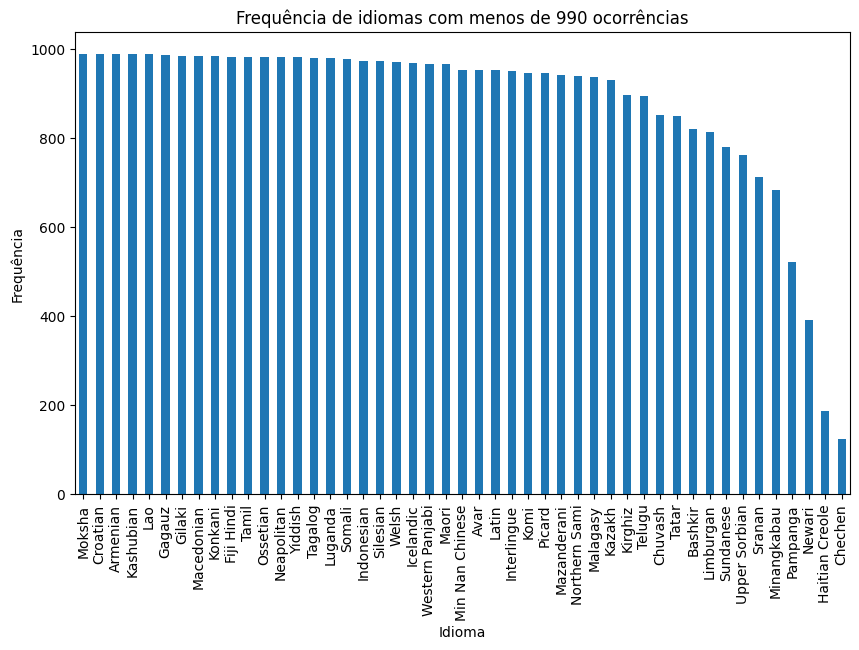

In [ ]:
language_counts = df['name'].value_counts()

# Filtrando para manter apenas idiomas com menos de 990 ocorrências
filtered_language_counts = language_counts[language_counts < 990]

plt.figure(figsize=(10, 6))
filtered_language_counts.plot(kind='bar')

plt.title('Frequência de idiomas com menos de 990 ocorrências')
plt.xlabel('Idioma')
plt.ylabel('Frequência')

plt.show()

In [ ]:
print(f"Quantidade de idiomas com exatamente 1000 aparições: {len(language_counts[language_counts == 1000])}")
print(f"Quantidade de idiomas com 990 aparições ou mais: {len(language_counts[language_counts >= 990])}")
print(f"Quantidade de idiomas com 900 aparições ou menos: {len(language_counts[language_counts <= 900])}")

Quantidade de idiomas com exatamente 1000 aparições: 78
Quantidade de idiomas com 990 aparições ou mais: 188
Quantidade de idiomas com 900 aparições ou menos: 14


Dos 235 idiomas, a maioria permaneceu com uma quantidade bem próxima de textos em relação ao dataset original. Porém, alguns foram bastante prejudicados, perdendo mais de 10% de sua frequência. Para o processamento geral, a técnica do Stratified K-Fold pode ajudar a mitigar os efeitos negativos de haver poucos textos desses idiomas, reduzindo a dificuldade de classificá-los e melhorando a acurácia das classificações.

#### Quantidade média de palavras por texto por idioma

Agora, será interessante saber a quantidade de palavras em cada texto, assim como a quantidade média de palavras por idioma. Para isso, uma nova coluna será criada para indicar a quantidade de palavras contidas nos textos.

In [ ]:
words_amount_df = df[['text', 'name', 'family']].copy()
words_amount_df['words'] = df['text'].apply(lambda x: len(x.split()))
words_amount_df

,text,name,family,words
0,klement gottwaldi surnukeha palsameeriti ning ...,Estonian,Uralic,45
1,sebes joseph pereira thomas på eng the jesuits...,Swedish,Indo-European,26
2,भारतीय स्वातन्त्र्य आन्दोलन राष्ट्रीय एवम क्षे...,Maithili,Indo-European,64
3,après lo cort periòde destabliment a basilèa t...,Occitan,Indo-European,147
4,ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...,Thai,Tai-Kadai,14
...,...,...,...,...
234995,wakati wa mimbahoma ya q ni vigumu kutibu kwa ...,Swahili (macrolanguage),Niger-Congo,29
234996,گیلون یک ته تاریخی منطقه‌ سفیدرود دلتای طرف ای...,Gilaki,Indo-European,62
234997,តាម​រយៈ​ការ​ចិញ្ចឹម​មនោសញ្ចេតនា​ជាតិនិយម​បែប​ន...,Central Khmer,Austronesian,10
234998,روس اک وفاق اے تے مارچ ء توں اسدیاں وفاقی اکائ...,Western Panjabi,Indo-European,95


Agrupamos pelo o nome do idioma, e tiramos a média da quantidade de palavras.

In [ ]:
average_words_per_language = words_amount_df.groupby('name')['words'].mean()

print(f"{average_words_per_language}")

print(f"\nQuantidade média de palavras por texto: {average_words_per_language.mean()}")

print(f"\nIdioma com a menor média de palavras por texto: {average_words_per_language.idxmin()}, com média de {average_words_per_language.min()} palavras")

print(f"\nIdioma com a maior média de palavras por texto: {average_words_per_language.idxmax()}, com média de {average_words_per_language.max()} palavras")

name
Achinese            45.192192
Afrikaans           69.174349
Albanian            78.811000
Alemannic German    54.227593
Amharic             58.427000
                      ...    
Xhosa               48.497497
Yakut               45.077154
Yiddish             60.946029
Yoruba              60.053053
Zeeuws              47.725726
Name: words, Length: 235, dtype: float64

Quantidade média de palavras por texto: 52.87204167529362

Idioma com a menor média de palavras por texto: Literary Chinese, com média de 1.3343343343343343 palavras

Idioma com a maior média de palavras por texto: Pushto, com média de 124.29476861167002 palavras


A partir dos dados do dataframe a língua com maior média de palavras é chamada "Pushto" e a com menor média é a "Literary Chinese". Porém, essa avaliação não serve muito bem dado a diferença semântica de palavra entre as diferentes famílias idiomáticas. No caso do chinês, os carácteres *hanzi* não formam fóneticamente uma palavra - cada ideograma representa uma idéia, originalmente iconográfica, e a sequência de ideias, apesar de não rigorosamente estruturada,
possibilita o trânsito da informação.

Essa associação de quantidade de palavras ou símbolos com a quantidade de informação vem da natureza fonética da escrita indo-européia. Dessa forma, não podemos considerar a quantidade de palavras como o único elemento capaz de influenciar no momento de treinamento e teste de todas as línguas.

Para algumas famílias linguísticas essa pode ser uma métrica importante, então, montaremos um gráfico com a quantidade média de palavras por texto por idioma e dividir por famílias.

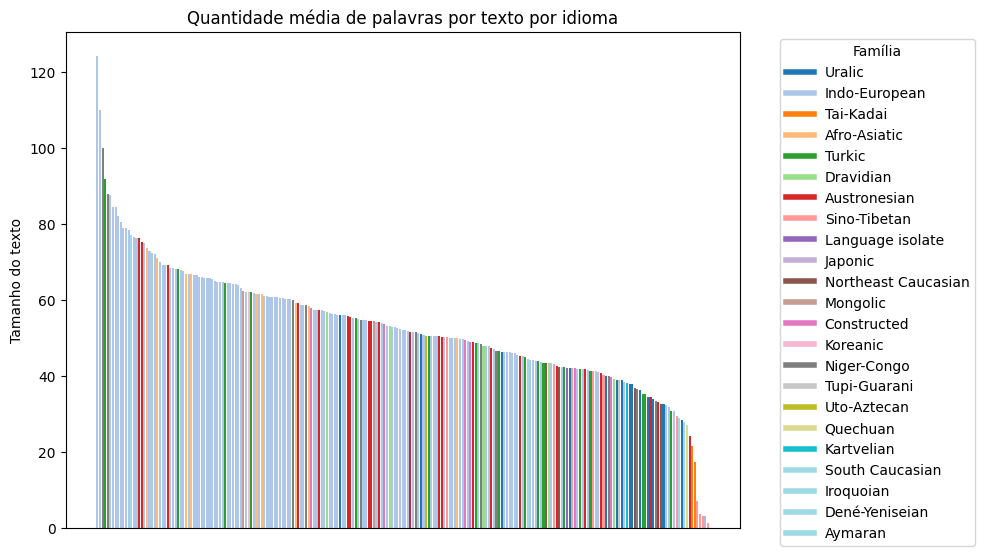

In [ ]:
families = words_amount_df['family'].unique()
color_map = {family: plt.cm.tab20(i) for i, family in enumerate(families)}

# adicionando as cores ao dataframe de acordo com a família de cada idioma
words_amount_df['color'] = words_amount_df['family'].map(color_map)

# deixando em ordem decrescente com as cores corretas
sorted_df = words_amount_df.groupby('name').agg({'words': 'mean', 'family': 'first'}).sort_values(by='words', ascending=False)
sorted_df['color'] = sorted_df['family'].map(color_map)

# gráfico de barras com cores por família
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(sorted_df)), sorted_df['words'], color=sorted_df['color'])

# adicionando a legenda
legend_elements = [Line2D([0], [0], color=color_map[family], lw=4, label=family) for family in families]
plt.legend(handles=legend_elements, title='Família', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks([]) # removendo os labels do eixo x
plt.title('Quantidade média de palavras por texto por idioma')
plt.ylabel('Tamanho do texto')
plt.tight_layout()
plt.show()

#### Nuvem de palavras de alguns idiomas

Abaixo vamos gerar nuvens de palavras de alguns idiomas. Essas *Word Clouds* representam visualmente as palavras mais frequentes de um idioma (no dataset), ela então fornece um rápido panorâma das classes sintáticas mais frequentes de uma língua. Estas características podem explicar futuramente os resultados da classificação de nosso modelo, e talvez seja o ideal exterminar alguns elementos da sintaxe.

In [ ]:
allTextsByLng = df.groupby('class')['text'].apply(' '.join).to_dict()

- Português

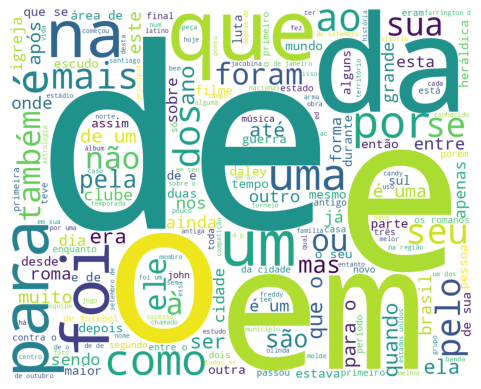

In [ ]:
wc = WordCloud(width = 1000, height = 800,
                background_color ='white',
                min_font_size = 10).generate(allTextsByLng['por'])
plt.axis("off")
plt.imshow(wc)

- Inglês

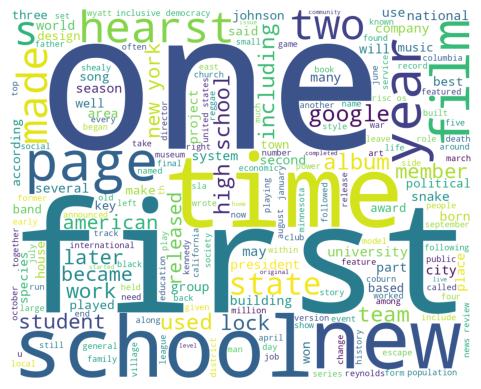

In [ ]:
wc = WordCloud(width = 1000, height = 800,
                background_color ='white',
                min_font_size = 10).generate(allTextsByLng['eng'])
plt.axis("off")
plt.imshow(wc)

- Espanhol

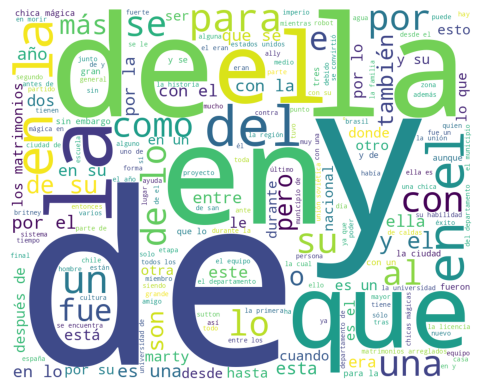

In [ ]:
wc = WordCloud(width = 1000, height = 800,
                background_color ='white',
                min_font_size = 10).generate(allTextsByLng['spa'])
plt.axis("off")
plt.imshow(wc)

- Coreano

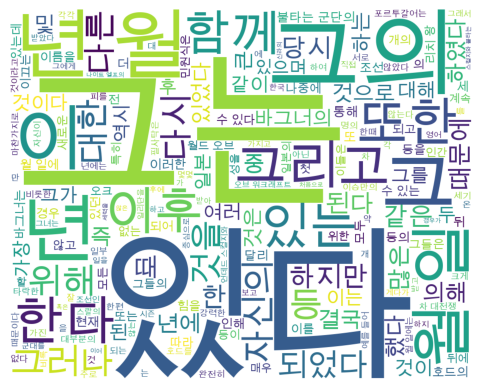

In [ ]:
wc = WordCloud(font_path = 'Arial-Unicode-Regular.ttf',
                width = 1000, height = 800,
                background_color ='white',
                min_font_size = 10).generate(allTextsByLng['kor'])
plt.axis("off")
plt.imshow(wc)

- Japonês

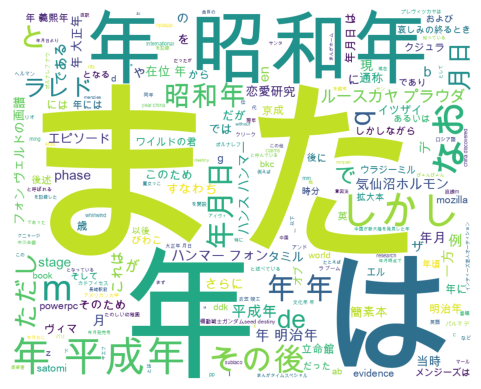

In [ ]:
wc = WordCloud(font_path = 'Arial-Unicode-Regular.ttf',
                width = 1000, height = 800,
                background_color ='white', min_font_size = 10).generate(allTextsByLng['jpn'])
plt.axis("off")
plt.imshow(wc)

- Italiano

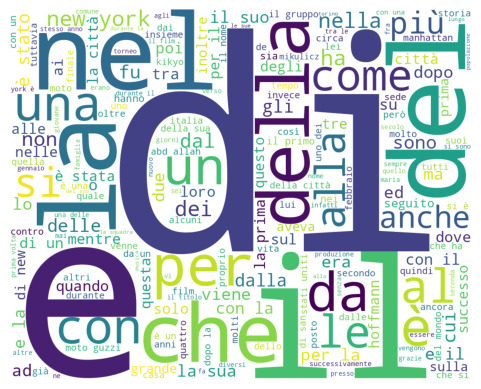

In [ ]:
wc = WordCloud(width = 1000, height = 800,
                background_color ='white', min_font_size = 10).generate(allTextsByLng['ita'])
plt.axis("off")
plt.imshow(wc)

Algo bem interessante de se ver vai ser a implicação do uso de estrangeirismos nos textos. Vemos o intruso *book* na nuvem de japonês e *new york* em italiano. É provável que existam confusões em relação a essas palavras dado a qualidade do dataset, cabe ao modelo ser capaz de relevar a má classificação de palavras independentes em prol do conjunto.

## Processamento

### Separação dos conjuntos de treinamento e teste

80% dos dados será utilizado para realizar o treinamento dos dados.

In [140]:
X = df['text']
y = df['name']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

O modelo que escolhemos foi o Multinomial Naive-Bayes. Como o modelo recebe como entrada valores numéricos, precisamos converter o texto de alguma forma. Approaches comuns pra conversão são Word2Vec ou FastText, mas estes são mais contextuais. Escolhemos então o TD-IDF pro embedding.

In [141]:
# pipeline para fazer o encoding tfidf e o modelo MultinomialNB
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB()),
])

# fitando o modelo no conjunto de treino
pipeline.fit(X_train, y_train)

# predict no conjunto de teste
y_pred = pipeline.predict(X_test)

# avaliação do modelo
print(f'Acurácia média: {accuracy_score(y_test, y_pred)}')

Acurácia média: 0.9388102725366876


In [142]:
tfidf_vectorizer = pipeline.named_steps['tfidf']
feature_size = len(tfidf_vectorizer.vocabulary_)
print(f"Pipeline feature size: {feature_size}")

Pipeline feature size: 1881812


### Tentando melhorar a precisão

Um parâmetro a ser alterado é o `alpha` do MultinomialNB. O alpha é responsável por adicionar um pequeno valor a todas as palavras do conjunto de teste, pois há uma chance de aparecer uma palavra que não se encontrava no treinamento, com risco de calcular como 0 a probabilidade da palavra ser de um idioma, mesmo ela sendo do idioma.
Também vamos limitar o número de `features` para melhorar a performance.

In [ ]:
# pipeline para fazer o encoding tfidf e o modelo MultinomialNB
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=100000)),
    ('clf', MultinomialNB(alpha = 0.1)),
])

# fitando o modelo no conjunto de treino
pipeline.fit(X_train, y_train)

# predict no conjunto de teste
y_pred = pipeline.predict(X_test)

#pega a lista de idiomas únicos
langs = y.unique()

# avaliação do modelo
report = classification_report(y_test, y_pred, labels = langs, target_names = langs)
print(f'Acurácia média: {accuracy_score(y_test, y_pred)}')
print(report)

Acurácia média: 0.9475672606568833
                            precision    recall  f1-score   support

                  Estonian       1.00      0.96      0.98       212
                   Swedish       0.98      1.00      0.99       196
                  Maithili       0.95      0.94      0.95       200
                   Occitan       1.00      0.88      0.94       211
                      Thai       0.91      0.98      0.94       207
                     Oromo       0.99      0.97      0.98       190
                 Limburgan       1.00      0.99      0.99       181
                  Gujarati       1.00      0.95      0.98       198
           Western Panjabi       1.00      0.97      0.98       205
                    Zeeuws       0.99      0.96      0.98       196
           Karachay-Balkar       1.00      0.99      0.99       207
            Haitian Creole       1.00      0.98      0.99        42
                    Picard       0.97      0.77      0.86       191
            

In [144]:
# salva o modelo
joblib.dump(pipeline, 'language_detection_model.pkl')

['language_detection_model.pkl']

### Matrizes de confusão

Como possuímos centenas de classe não será prático entender individualmente as métricas. Vamos buscar entender as classes cujo modelo mais confunde:

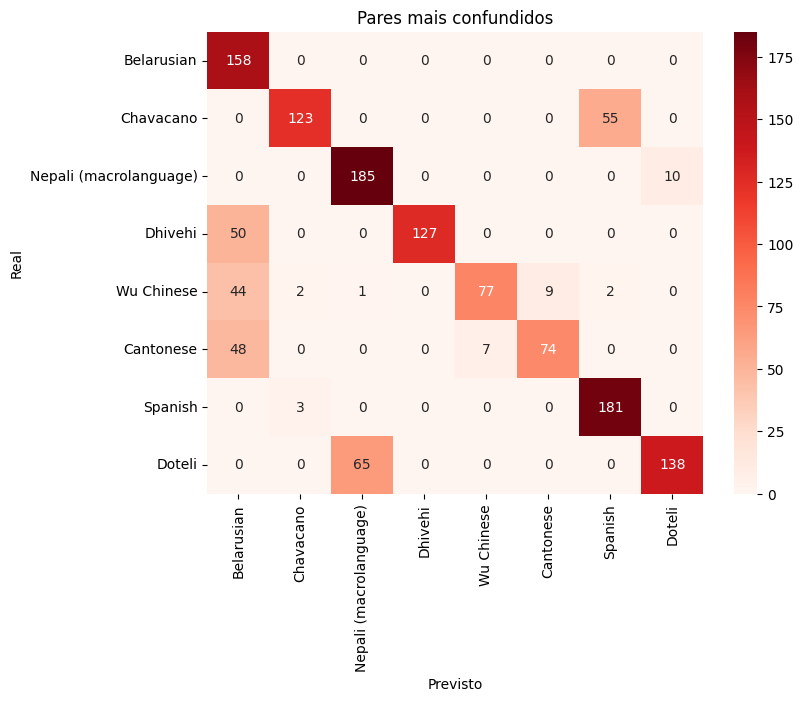


5 pares mais confundidos:
Real: Doteli, Previsto: Nepali (macrolanguage), Valor: 65
Real: Chavacano, Previsto: Spanish, Valor: 55
Real: Dhivehi, Previsto: Belarusian, Valor: 50
Real: Cantonese, Previsto: Belarusian, Valor: 48
Real: Wu Chinese, Previsto: Belarusian, Valor: 44


In [145]:
# gera a matriz de confusão e transforma em um dataset
cm = confusion_matrix(y_test, y_pred, labels=langs)
cm_df = pd.DataFrame(cm, index=langs, columns=langs)

# coloca todos os pares de idiomas e o valor da célula da matriz de confusão na lista
confusion_total = []
for i in range(len(cm)):
    for j in range(len(cm[i])):
        if i != j and cm[i][j] > 0:
            confusion_total.append((langs[i], langs[j], cm[i][j]))

# ordena a lista pelo número de confusão e pega os 5 maiores pares
confusion_total = sorted(confusion_total, key=lambda x: x[2], reverse=True)
top_confusions = confusion_total[:5]

# idiomas presentes nos pares
top_langs = list(set([true for true, pred, _ in top_confusions] +
                      [pred for true, pred, _ in top_confusions]))

# filtra o dataset somente para aqueles idiomas
top_cm_df = cm_df.loc[top_langs, top_langs]

# monta o gráfico
plt.figure(figsize=(8, 6))
sns.heatmap(top_cm_df, annot=True, fmt='d', cmap='Reds', xticklabels=top_cm_df.columns, yticklabels=top_cm_df.index)
plt.title('Pares mais confundidos')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()

print("\n5 pares mais confundidos:")
for real_lang, pred_lang, count in top_confusions:
    print(f"Real: {real_lang}, Previsto: {pred_lang}, Valor: {count}")

Idiomas com o pior F1-score:

In [146]:
report = classification_report(y_test, y_pred, labels = langs, target_names = langs, output_dict=True)

report_df = pd.DataFrame(report).transpose()

worst_lang = report_df.sort_values(by='f1-score').head(3)

print("3 idiomas com pior F1-score:\n")
print(worst_lang)

3 idiomas com pior F1-score:

            precision    recall  f1-score  support
English      0.220096  1.000000  0.360784    184.0
Cantonese    0.770833  0.362745  0.493333    204.0
Wu Chinese   0.777778  0.361502  0.493590    213.0


### Testando o modelo com idiomas limitados

In [121]:
idiomas = ['English', 'Italian', 'French', 'Spanish', 'German', 'Portuguese', 'Japanese', 'Russian', 'Arabic', 'Korean']

reduced_df = df[df['name'].isin(idiomas)]

X = reduced_df['text'].values
y = reduced_df['name'].values

In [122]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
folds = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    folds.append(accuracy_score(y_test, y_pred))

# avaliação do modelo
print(f'Acurácia máxima: {max(folds)*100}%\n')
print(f'Acurácia mínima: {min(folds)*100}%\n')
print(f'Acurácia média: {mean(folds)*100}%\n')
print(f'Desvio padrão das acurácias: {stdev(folds)*100}\n')

Acurácia máxima: 96.69338677354709%

Acurácia mínima: 94.7947947947948%

Acurácia média: 95.74383000234702%

Desvio padrão das acurácias: 0.5788980581654044



In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.75)

In [124]:
pipeline.fit(X_train, y_train)

# predict no conjunto de teste
y_pred = pipeline.predict(X_test)

report = classification_report(y_test, y_pred, target_names=idiomas)

# avaliação do modelo
print(f'Acurácia média: {accuracy_score(y_test, y_pred)}\n')
print(report)

Acurácia média: 0.9415142208572573

              precision    recall  f1-score   support

     English       1.00      1.00      1.00       754
     Italian       0.87      1.00      0.93       750
      French       0.71      0.99      0.83       729
     Spanish       0.98      0.98      0.98       777
      German       1.00      0.98      0.99       753
  Portuguese       1.00      0.55      0.71       754
    Japanese       1.00      0.99      0.99       745
     Russian       0.99      0.97      0.98       746
      Arabic       1.00      0.99      0.99       745
      Korean       0.99      0.98      0.98       736

    accuracy                           0.94      7489
   macro avg       0.95      0.94      0.94      7489
weighted avg       0.95      0.94      0.94      7489



#### Considerando somente os idiomas utilizados pelos notebooks públicos presentes na seção 5. Trabalhos relacionados

In [125]:
idiomas = ['English', 'Italian', 'French', 'Spanish', 'German']

reduced_df = df[df['name'].isin(idiomas)]

X = reduced_df['text'].values
y = reduced_df['name'].values

Usando o mesmo método de avaliação do MultinomialNB:

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8, random_state=0)

In [127]:
pipeline.fit(X_train, y_train)

# predict no conjunto de teste
y_pred = pipeline.predict(X_test)

report = classification_report(y_test, y_pred, target_names=idiomas)

# avaliação do modelo
print(f'Acurácia média: {accuracy_score(y_test, y_pred)}\n')
print(report)

Acurácia média: 0.9874718115760461

              precision    recall  f1-score   support

     English       0.97      1.00      0.98       801
     Italian       0.98      0.99      0.99       805
      French       0.99      0.98      0.99       809
     Spanish       1.00      0.98      0.99       797
      German       1.00      0.98      0.99       779

    accuracy                           0.99      3991
   macro avg       0.99      0.99      0.99      3991
weighted avg       0.99      0.99      0.99      3991



Usando o mesmo método de avaliação do GaussianNB:

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [129]:
pipeline.fit(X_train, y_train)

# predict no conjunto de teste
y_pred = pipeline.predict(X_test)

report = classification_report(y_test, y_pred, target_names=idiomas)

# avaliação do modelo
print(f'Acurácia média: {accuracy_score(y_test, y_pred)}\n')
print(report)

Acurácia média: 0.9929859719438878

              precision    recall  f1-score   support

     English       0.97      1.00      0.99       195
     Italian       1.00      1.00      1.00       204
      French       0.99      1.00      0.99       191
     Spanish       1.00      0.99      1.00       209
      German       1.00      0.97      0.99       199

    accuracy                           0.99       998
   macro avg       0.99      0.99      0.99       998
weighted avg       0.99      0.99      0.99       998

